# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Первичный осмотр 

In [1]:
# импортируем библиотеки
import os
import numpy as np
import pandas as pd
import re
import warnings
import matplotlib.pyplot as plt


from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    RandomizedSearchCV,
    train_test_split
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.metrics import mean_squared_error

# настройки
warnings.filterwarnings("ignore")
pd.set_option('display.max_column', None)

# константы заглавными буквами
RANDOM_STATE = 42

In [2]:
# Откроем и прочитаем файл
pth1 = 'datasets/autos.csv'
pth2 = '/datasets/autos.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, parse_dates = ['DateCrawled'])
elif os.path.exists(pth1):
    data = pd.read_csv(pth2, parse_dates = ['DateCrawled'])
else:
    print('wrong somethings')

In [3]:
# Выведем на экран таблицу
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
%%time
rename = ['_'.join(re.split('\B(?=[A-Z])', i)).lower() for i in data.columns]
data.columns = rename
data.head(3)

CPU times: total: 0 ns
Wall time: 997 µs


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [5]:
#Посмотрим общую информацию
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  object        
 13  number_of_pictures  354369 no

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
cat_columns = ['date_crawled', 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 
               'repaired', 'date_created', 'last_seen']
print(data['date_crawled'].max())
data[cat_columns].describe()

2016-04-07 14:36:58


,date_crawled,vehicle_type,gearbox,model,fuel_type,brand,repaired,date_created,last_seen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17
first,2016-03-05 14:06:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Узнаем долю пропусков в процентах от общего количества
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
date_crawled,0.000000
price,0.000000
vehicle_type,11.000000
registration_year,0.000000
gearbox,6.000000
power,0.000000
model,6.000000
kilometer,0.000000
registration_month,0.000000
fuel_type,9.000000


**Вывод**: В данных много пропусков. Есть аномальные значения. Некоторые столбцы не несут в себе полезной информации. Нужна предобработка данных.

### Предобработка данных

**Избавимся сначала от бесполезных столбцов, таких как  `date_created`, `number_of_pictures`, `last_seen`, `postal_code`, `date_crawled`**

In [8]:
data = data.drop(['date_created', 'number_of_pictures', 'last_seen', 'postal_code', 'date_crawled'], axis=1)
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

In [9]:
data = data.fillna('no_info')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        354369 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox             354369 non-null  object
 4   power               354369 non-null  int64 
 5   model               354369 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           354369 non-null  object
 9   brand               354369 non-null  object
 10  repaired            354369 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [10]:
# Проверка на дубликаты
data.duplicated(subset=data.columns).sum()


27543

In [11]:
#Посмотрим на дубликаты
data[data.duplicated(subset=data.columns, keep=False)==True].sort_values('brand')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
9089,7000,wagon,2003,auto,250,156,150000,7,petrol,alfa_romeo,no
169681,500,sedan,1999,manual,120,156,150000,8,petrol,alfa_romeo,no
204714,2500,wagon,2004,manual,160,156,150000,0,petrol,alfa_romeo,no
325479,2500,wagon,2004,manual,160,156,150000,0,petrol,alfa_romeo,no
306348,2600,wagon,2004,manual,140,156,150000,4,gasoline,alfa_romeo,no
...,...,...,...,...,...,...,...,...,...,...,...
241119,3100,sedan,2001,manual,170,s60,150000,5,petrol,volvo,no
156398,8333,sedan,2006,auto,185,other,150000,7,gasoline,volvo,no
147369,1950,wagon,2000,manual,90,v40,150000,2,petrol,volvo,no
251573,12000,convertible,2007,auto,179,c_reihe,125000,8,gasoline,volvo,no


In [12]:
#Удаление дубликатов
data = data.drop_duplicates(subset=data.columns)
data.duplicated(subset=data.columns).sum()

0

**Перед работой с аномалиями, узнаем немного историю автомобилестроения.**

**В 1806 году появились первые машины, приводимые в движение двигателями внутреннего сгорания на англ. fuel gas, что привело к появлению в 1885 году повсеместно используемого сегодня газолинового или бензинового двигателя внутреннего сгорания.В 1885 году немецкий изобретатель Карл Бенц в своем гараже создал автомобиль под названием Motorwagen. Спустя год он получил на него патент. Официально Моторваген считается первым автомобилем с двигателем внутреннего сгорания, хотя споры по этому поводу не утихают до сих пор. Мощность 1 автомобиля оценивается как 0,75 л.с., а самый мощный на данный момент автомобиль  имеет свыше 1600 л.с.**

**Т.к. сервис по продаже автомобилей с пробегом врядли будет отдавать товар бесплатно, цена должна быть выше 0**

**Построим boxplot чтобы увидеть доверительный интервал и аномальные выбросы.**

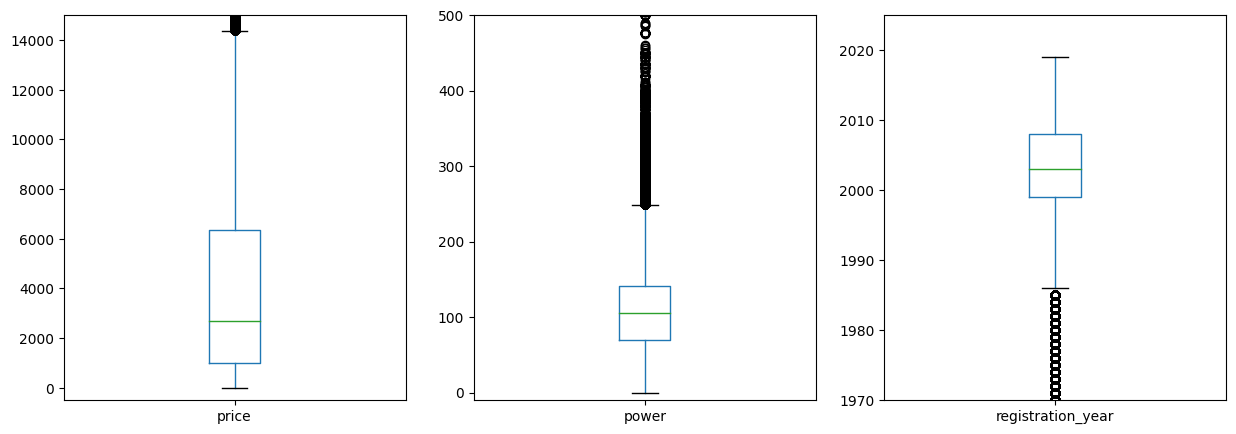

In [13]:
plt.subplot(1, 3, 1)
data['price'].plot(kind='box', figsize=(15, 5))
plt.ylim(-500, 15000)
plt.subplot(1, 3, 2)
data['power'].plot(kind='box', figsize=(15, 5))
plt.ylim(-10, 500)
plt.subplot(1, 3, 3);
data['registration_year'].plot(kind='box', figsize=(15, 5))
plt.ylim(1970, 2025);

**Посмотрим поближе на распределение цены с помощью гистограммы** 

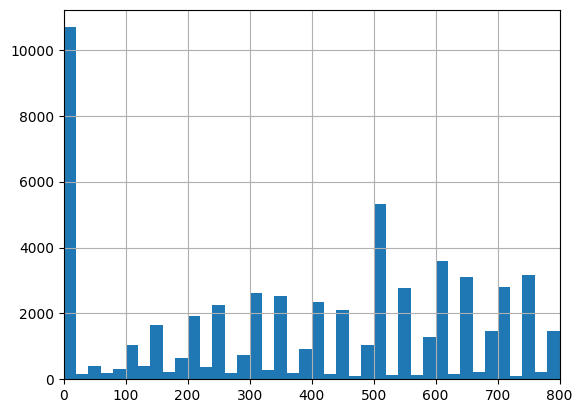

In [14]:
data['price'].hist(bins=1000)
plt.xlim(0, 800);

**Вывод:** Как видим до 100 евро цена имеет небольшие выбросы. Будем считать что цена на самый дешевый атомобиль на сервисе начинается с 100.

**Избавимся от аномальных значений, взяв за основу исторические данные и графики распределения. Данные были выгружены в 2016 году, а значит все значения `registration_year` должны быть меньше этого значения**

In [15]:
data = data.query(' 1700 > power > 0 and 2017 > registration_year > 1800 and price > 100')
data.describe()

,price,registration_year,power,kilometer,registration_month
count,271879.000000,271879.000000,271879.000000,271879.00000,271879.000000
mean,4863.419543,2002.797884,121.235145,128204.09079,5.979697
std,4614.709483,6.604978,59.954717,36837.52911,3.585033
min,101.000000,1910.000000,1.000000,5000.00000,0.000000
25%,1350.000000,1999.000000,77.000000,125000.00000,3.000000
50%,3200.000000,2003.000000,111.000000,150000.00000,6.000000
75%,6999.000000,2007.000000,150.000000,150000.00000,9.000000
max,20000.000000,2016.000000,1689.000000,150000.00000,12.000000


**Вывод:** Первичная обработка данных завершена. Данные готовы для анализа.

## Обучение моделей

### Подготовка данных для моделей

**Для анализа будем использовать модели: ` Ridge`, ` RandomForestRegressor`, ` LightGBMRegressor`.**

In [16]:
## Определим признаки и целевой признак
features = data.drop(['price'], axis=1)
target = data['price']

# Разбивка на тренировочную и валидационную.
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)
## Посмотрим распределение признаков
display(features_train.describe(include='all'))
features_test.describe(include='all')

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
count,203909,203909.000000,203909,203909.000000,203909,203909.000000,203909.000000,203909,203909,203909
unique,9,NaN,3,NaN,250,NaN,NaN,8,40,3
top,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no
freq,57031,NaN,159579,NaN,16712,NaN,NaN,129031,43507,153535
mean,NaN,2002.782820,NaN,121.264736,NaN,128214.546685,5.975401,NaN,NaN,NaN
std,NaN,6.598606,NaN,60.177680,NaN,36824.659199,3.588654,NaN,NaN,NaN
min,NaN,1910.000000,NaN,1.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN
25%,NaN,1999.000000,NaN,77.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN
50%,NaN,2003.000000,NaN,110.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN
75%,NaN,2007.000000,NaN,150.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN


,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
count,67970,67970.000000,67970,67970.000000,67970,67970.000000,67970.000000,67970,67970,67970
unique,9,NaN,3,NaN,246,NaN,NaN,8,40,3
top,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no
freq,18892,NaN,53257,NaN,5632,NaN,NaN,42888,14607,51216
mean,NaN,2002.843078,NaN,121.146373,NaN,128172.723260,5.992585,NaN,NaN,NaN
std,NaN,6.623899,NaN,59.281152,NaN,36876.364996,3.574144,NaN,NaN,NaN
min,NaN,1910.000000,NaN,1.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN
25%,NaN,1999.000000,NaN,76.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN
50%,NaN,2003.000000,NaN,112.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN
75%,NaN,2007.000000,NaN,150.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN


**Можем заметить, что уникальные значения моделей авто в тестовой и обучающей выборке не совпадают. Чтобы не было проблем с моделями обучения, нужно будет закодировать категориальные переменные так, чтобы при нахождении неизвестной ранее категории модель не падала с ошибкой. Для этого подойдет OHE.**

In [17]:
## ПОсмотрим различающиеся значения 
models_train = set(features_train['model'].unique())
models_test = set(features_test['model'].unique())
print(f'Только в тренировочной выборке есть значения:{models_train - models_test}')
print(f'Только в тecтовой выборке есть значения:{models_test - models_train}')

Только в тренировочной выборке есть значения:{'range_rover_evoque', 'serie_2', 'elefantino', 'rangerover'}
Только в тecтовой выборке есть значения:set()


**Т.к. для разных моделей, нам придется по разному кодировать категориальные значения, то создадим для каждой свою выборку.** 

In [18]:
## для ` Ridge`
features_train_ridge = features_train.copy()
features_test_ridge = features_test.copy()

## для ` LightGBMRegressor`
features_train_rf = features_train.copy()
features_test_rf= features_test.copy()

## для `RandomForestRegressor` 
features_train_lgb = features_train.copy()
features_test_lgb= features_test.copy()

In [19]:
#категориальные признаки для OHE Ridge
ohe_features_ridge = features_train.select_dtypes(include='object').columns.to_list()
print('категориальные признаки для OHE Ridge:','\n', ohe_features_ridge)

#категориальные признаки для OHE RandomForestRegressor
ohe_features_rf = ohe_features_ridge.copy()
ohe_features_rf.remove('model')
print('категориальные признаки для OHE RandomForestRegressor:','\n', ohe_features_rf)

#численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
print('численные признаки:','\n', num_features)

#категориальные признаки для LightGBM
cat_features = ohe_features_ridge.copy()
features_train_lgb[cat_features] = features_train_lgb[cat_features].astype('category')
features_test_lgb[cat_features] = features_test_lgb[cat_features].astype('category')
features_train_lgb.info()

категориальные признаки для OHE Ridge: 
 ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
категориальные признаки для OHE RandomForestRegressor: 
 ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']
численные признаки: 
 ['registration_year', 'power', 'kilometer', 'registration_month']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 203909 entries, 284360 to 152392
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        203909 non-null  category
 1   registration_year   203909 non-null  int64   
 2   gearbox             203909 non-null  category
 3   power               203909 non-null  int64   
 4   model               203909 non-null  category
 5   kilometer           203909 non-null  int64   
 6   registration_month  203909 non-null  int64   
 7   fuel_type           203909 non-null  category
 8   brand               203909 non-null  category
 9  

### Перебор гипрепараметров и поиск лучшей модели

**Будем использовать пайплайн вместе с кросс-валидацией. Это позволит кодировать и масштабировать отдельно каждую тренировочную и валидационную выборки внутри кросс-валидации (без «подглядывания»)**

#### Модель Ridge

In [20]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
col_transformer_ridge = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_ridge
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough'
)

In [21]:
# random_state не перебирается, задаём его прямо в модели
model_ridge = Ridge(random_state=RANDOM_STATE)

# создаем конвейер
pipeline_ridge = make_pipeline(col_transformer_ridge, model_ridge)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'ridge__alpha': np.arange(0, 0.21, 0.01),
}

In [22]:
# %%time
# gs_ridge_pl = GridSearchCV(
#     pipeline_ridge,
#     param_grid=param_grid_ridge,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     verbose=1
# )

# gs_ridge_pl.fit(features_train_ridge, target_train)

# gs_ridge_best_score = gs_ridge_pl.best_score_ * -1
# gs_ridge_best_params = gs_ridge_pl.best_params_

# # лучшее значение RMSE на кросс-валидации
# print(f'best_score: {gs_ridge_best_score}')
# # лучшие гиперпараметры
# print(f'best_params: {gs_ridge_best_params}')

In [23]:
# print('Среднее время обучения:', gs_ridge_pl.cv_results_['mean_fit_time'].mean())
# print('Среднее время предсказания:', gs_ridge_pl.cv_results_['mean_score_time'].mean())

Среднее время обучения: 1.0351653916495185

Среднее время предсказания: 0.10954548517862954

 - best_score: 2678.034382051742
 - best_params: {'ridge__alpha': 0.02}
 - CPU times: total: 8.09 s
 - Wall time: 38 s

#### Модель RandomForest

In [24]:

col_transformer_rf= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_rf
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        ['model']
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough'
)

In [25]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

# создаем конвейер
pipline_rf = make_pipeline(col_transformer_rf, model_rf)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_rf = {
    'randomforestregressor__n_estimators': range(50, 251, 50),
    'randomforestregressor__max_depth':range(2, 11),
    'randomforestregressor__min_samples_split': (2, 3, 4),
}

In [26]:
# %%time
# # получается достаточно много комбинаций гиперпараметров при переборе
# # будем использовать RandomizedSearchCV, он работает на много быстрее
# gs_rf = RandomizedSearchCV(
#     pipline_rf,
#     param_distributions=param_grid_rf,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     cv=3,
#     verbose=30,
#     random_state=RANDOM_STATE
# )

# gs_rf.fit(features_train_rf, target_train)

# # лучшее значение RMSE и гиперпараметров на кросс-валидации
# gs_rf_best_score = gs_rf.best_score_ * -1
# gs_rf_best_params = gs_rf.best_params_
# print(f'best_score: {gs_rf_best_score}')
# print(f'best_params: {gs_rf_best_params}')

In [27]:
# print('Среднее время обучения:', gs_rf.cv_results_['mean_fit_time'].mean())
# print('Среднее время предсказания:', gs_rf.cv_results_['mean_score_time'].mean())

Среднее время обучения: 137.65193184216815

Среднее время предсказания: 0.8597742239634197

Fitting 3 folds for each of 10 candidates, totalling 30 fits
 - CPU times: total: 9min 15s
 - Wall time: 28min 34s

 - best_score: 1892.2422428296404
 - best_params: {
      - 'randomforestregressor__n_estimators': 200, 
      - 'randomforestregressor__min_samples_split': 3, 
      -  'randomforestregressor__max_depth': 10}

#### LightGBMRgressor

In [28]:
# словарь с гиперпараметрами и значениями, которые хотим перебрать
params_grid_lgb = {
    'n_estimators': range(50, 251, 50),
    'num_leaves': (50, 70, 90),
    'max_depth': range(2, 11),
    'learning_rate': (0.01, 0.05)
}


In [29]:
# %%time
# lgb_reg = LGBMRegressor(random_state=RANDOM_STATE, categorical_feature=cat_features)

# gs_lgb = RandomizedSearchCV(
#     lgb_reg,
#      params_grid_lgb,
#      scoring='neg_root_mean_squared_error',
#      n_jobs=-1,
#      cv=3,
#      verbose=30,
#      random_state=RANDOM_STATE
#  )

# gs_lgb.fit(features_train_lgb, target_train)

# # лучшее значение RMSE и гиперпараметров на кросс-валидации
# gs_lgb_best_score = gs_lgb.best_score_ * -1
# gs_lgb_best_params = gs_lgb.best_params_
# print(f'best_score: {gs_lgb_best_score}')
# print(f'best_params: {gs_lgb_best_params}')

In [30]:
# print('Среднее время обучения:', gs_lgb.cv_results_['mean_fit_time'].mean())
# print('Среднее время предсказания:', gs_lgb.cv_results_['mean_score_time'].mean())

Среднее время обучения: 2.806015419960022

Среднее время предсказания: 1.1815109650293985

Fitting 3 folds for each of 10 candidates, totalling 30 fits
 - best_score: 1601.5184014304066
 - best_params: {
     - 'num_leaves': 70, 
     - 'n_estimators': 150, 
     - 'max_depth': 9, 
     - 'learning_rate': 0.05}
 - CPU times: total: 4.44 s
 - Wall time: 22.1 s

## Анализ моделей

**Согласно требованиям заказчика, лучшая модель должна оцениваться по следующим критериям:**
 - качество предсказания. Значение метрики RMSE должно быть меньше 2500.
 - время обучения
 - скорость предсказания

**Оценка будет проводится следующим образом**:
 - У лучшей модели  2 из 3 критерий превосходят другие модели.
 - Главный критерий качество предсказания. Если не выполняется условие RMSE<2500. Модель отбрасывается.

In [31]:
result = pd.DataFrame(
    [[2678.034, 1892.242, 1601.518], ['39s', '28min 34s', '22.1 s'],
     [1.0351, 137.651, 2.806], [0.1095,  0.8597, 1.181]],
    index=['RMSE','hyperparameter_optimization_time', 'mean_fit_time', 'mean_predict_time'],
    columns=['Ridge', 'RandomForestRegressor', 'LightGBMRegressor']
)
result

,Ridge,RandomForestRegressor,LightGBMRegressor
RMSE,2678.034,1892.242,1601.518
hyperparameter_optimization_time,39s,28min 34s,22.1 s
mean_fit_time,1.0351,137.651,2.806
mean_predict_time,0.1095,0.8597,1.181


**Вывод:** Модель `Ridge` не соответствует главному критерию, поэтому отбрасывается. Как мы можем наблюдать, `LightGBMRegressor` превосходит другой по первым двум критериям, следовательно является лучшей моделью для заказчика. 

## Проверка на тестовой выборке лучшей модели

In [32]:
%%time
lgb_reg = LGBMRegressor(
    num_leaves=70,
    n_estimators=150,
    max_depth=9,
    learning_rate=0.05,
    random_state=RANDOM_STATE, 
    categorical_feature=cat_features)

lgb_reg.fit(features_train_lgb, target_train)

CPU times: total: 4 s
Wall time: 1.08 s


LGBMRegressor(categorical_feature=['vehicle_type', 'gearbox', 'model',
                                   'fuel_type', 'brand', 'repaired'],
              learning_rate=0.05, max_depth=9, n_estimators=150, num_leaves=70,
              random_state=42)

In [33]:
%%time
predict_test = lgb_reg.predict(features_test_lgb)
print(f'rmse: {np.sqrt(mean_squared_error(target_test, predict_test))}')

rmse: 1570.6648985880204
CPU times: total: 1.44 s
Wall time: 379 ms


**Вывод:** LightGBMRegressor на тестовой выборке дал удовлетворяющие всем критериям результаты.

## Вывод

**Целью данного анализа было нахождение модели для определения стоимости автомобилей с пробегом. Заказчик предоставлял исторические данные: технические характеристики, комплектации и цены автомобилей. В ходе  исследованния были обнаружены проблемы с данными, а именно:**
 - Пропушенные значения в столбцах: vehicle_type, gearbox, model, fuel_type, brand, repaired.
 - Аномальные значения в столбцах: price, registration_year, power	
 
**Рекомендуются сделать данные столбцы обязательными для заполнения, а также делать проверку на валидность при вводе данных клиентом.** 

**Лучшей моделью машинного обучения для заказчика, является модель LightGBMRegressor.**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей